# Elo Merchant Category Recommendation - LightGBM
End date: _2019. february 19._<br/>

This tutorial notebook is the second part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [20]:
import os
import gc
import math
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

random.seed(1)
threshold = 0.5

In [21]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Data loading
### Train and test data

In [22]:
df_train = pd.read_csv("preprocessed/train_parsed.csv")
df_train = reduce_mem_usage(df_train)

df_test = pd.read_csv("preprocessed/test_parsed.csv")
df_test = reduce_mem_usage(df_test)

print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage: 13.86 MB
Reduced memory usage:  5.01 MB (63.9% reduction)
Starting memory usage:  7.55 MB
Reduced memory usage:  2.95 MB (60.9% reduction)
201,917 records and 9 features in train set.
123,623 records and 8 features in test set.


In [23]:
df_train[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,target,year,month,number_of_transactions
0,C_ID_92a2005557,2017-06-01,5,2,1,-0.820312,2017,6,260
1,C_ID_3d0044924f,2017-01-01,4,1,0,0.392822,2017,1,350
2,C_ID_d639edf6cd,2016-08-01,2,2,0,0.687988,2016,8,43


In [24]:
df_test[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,year,month,number_of_transactions
0,C_ID_0ab67a22ab,2017-04-01,3,3,1,2017.0,4.0,68
1,C_ID_130fd0cbdd,2017-01-01,2,3,0,2017.0,1.0,78
2,C_ID_b709037bc5,2017-08-01,5,1,1,2017.0,8.0,13


### Transactions & merchants

In [25]:
df_new_trans = pd.read_csv("preprocessed/trans_merch_new_agg.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("preprocessed/trans_merch_hist_agg.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 267.72 MB
Reduced memory usage: 67.21 MB (74.9% reduction)
Starting memory usage: 300.52 MB
Reduced memory usage: 92.52 MB (69.2% reduction)


In [26]:
df_hist_trans.drop(['Unnamed: 0'], inplace=True, axis=1)
df_new_trans.drop(['Unnamed: 0'], inplace=True, axis=1)

In [27]:
df_new_trans[:3]

,card_id,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_active_months_lag3_sum,new_active_months_lag3_mean,new_active_months_lag6_sum,new_active_months_lag6_mean,new_active_months_lag12_sum,new_active_months_lag12_mean,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_part_of_month_mean,new_purchase_part_of_month_median
0,C_ID_00007093c1,1,2,1,6.0,3.0,12.0,6.0,19.0,9.500000,...,1,0,0.707031,2.000000,2.0,2,2,0.000000,0.000000,0.0
1,C_ID_0001238066,1,26,1,75.0,3.0,150.0,6.0,292.0,11.679688,...,6,0,1.799805,1.345703,1.0,2,1,0.485107,1.345703,1.5
2,C_ID_0001506ef0,1,2,1,3.0,3.0,6.0,6.0,12.0,12.000000,...,4,3,0.707031,1.000000,1.0,1,1,0.000000,1.500000,1.5


In [28]:
df_hist_trans[:3]

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_active_months_lag3_sum,hist_active_months_lag3_mean,hist_active_months_lag6_sum,hist_active_months_lag6_mean,hist_active_months_lag12_sum,hist_active_months_lag12_mean,...,hist_purchase_dayofweek_max,hist_purchase_dayofweek_min,hist_purchase_dayofweek_std,hist_purchase_quarter_mean,hist_purchase_quarter_median,hist_purchase_quarter_max,hist_purchase_quarter_min,hist_purchase_quarter_std,hist_purchase_part_of_month_mean,hist_purchase_part_of_month_median
0,C_ID_00007093c1,1,114.0,0.765137,447.0,3.0,894.0,6.0,1776.0,11.921875,...,6,0,1.869141,2.476562,2.0,4,1,1.100586,0.751465,1.0
1,C_ID_0001238066,1,120.0,0.975586,369.0,3.0,738.0,6.0,1476.0,12.000000,...,6,0,1.909180,2.763672,4.0,4,1,1.471680,1.195312,1.0
2,C_ID_0001506ef0,1,62.0,0.939453,198.0,3.0,396.0,6.0,782.0,11.851562,...,6,0,1.797852,2.515625,3.0,4,1,1.406250,0.666504,0.5


### Merging

Join the data of the merchants and the transactions to the training and test set.

In [29]:
%%time
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')

CPU times: user 2.89 s, sys: 594 ms, total: 3.48 s
Wall time: 3.48 s


In [30]:
%%time
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

CPU times: user 2.11 s, sys: 250 ms, total: 2.36 s
Wall time: 2.31 s


In [31]:
del df_hist_trans
del df_new_trans
gc.collect()

9128

In [32]:
df_train[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,target,year,month,number_of_transactions,hist_transactions_count,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_part_of_month_mean,new_purchase_part_of_month_median
0,C_ID_92a2005557,2017-06-01,5,2,1,-0.820312,2017,6,260,1,...,6.0,0.0,2.029297,1.478516,1.0,2.0,1.0,0.510742,1.0,1.0
1,C_ID_3d0044924f,2017-01-01,4,1,0,0.392822,2017,1,350,1,...,4.0,0.0,1.643555,1.000000,1.0,1.0,1.0,0.000000,1.0,1.0
2,C_ID_d639edf6cd,2016-08-01,2,2,0,0.687988,2016,8,43,1,...,5.0,5.0,NaN,2.000000,2.0,2.0,2.0,NaN,2.0,2.0


In [33]:
df_test[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,year,month,number_of_transactions,hist_transactions_count,hist_authorized_flag_sum,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_part_of_month_mean,new_purchase_part_of_month_median
0,C_ID_0ab67a22ab,2017-04-01,3,3,1,2017.0,4.0,68,1,44.0,...,5.0,2.0,1.527344,1.000000,1.0,1.0,1.0,0.000000,1.000000,1.0
1,C_ID_130fd0cbdd,2017-01-01,2,3,0,2017.0,1.0,78,1,77.0,...,6.0,0.0,2.291016,1.444336,1.0,2.0,1.0,0.526855,0.777832,1.0
2,C_ID_b709037bc5,2017-08-01,5,1,1,2017.0,8.0,13,1,9.0,...,3.0,1.0,1.414062,1.000000,1.0,1.0,1.0,0.000000,0.500000,0.5


## Training

### LightGBM
For more details click [here](https://lightgbm.readthedocs.io/en/latest/).

In [34]:
features = ['new_most_recent_sales_range_mean', 'new_merchant_id_nunique', 'new_purchase_weekofyear_median', 'hist_avg_purchases_lag6_mean', 'new_purchase_weekofyear_max', 'new_purchase_day_max', 'hist_avg_purchases_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_sales_lag3_mean', 'new_purchase_quarter_mean', 'new_avg_sales_lag6_sum', 'new_most_recent_sales_range_sum', 'new_month_lag_mean', 'new_purchase_dayofweek_mean', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_dayofweek_std', 'new_purchase_day_mean', 'new_purchase_quarter_median', 'new_subsector_id_merch_nunique', 'new_purchase_quarter_std', 'new_purchase_dayofweek_min', 'new_most_recent_purchases_range_mean', 'new_number_of_transactions_median', 'new_avg_purchases_lag12_sum', 'hist_avg_purchases_lag6_sum', 'new_month_lag_min', 'hist_avg_purchases_lag3_mean', 'new_purchase_day_std', 'new_number_of_transactions_std', 'new_most_recent_purchases_range_sum', 'new_purchase_weekofyear_min', 'new_purchase_day_median', 'new_numerical_1_mean', 'new_purchase_hour_max', 'hist_category_2_merch_mean', 'new_avg_purchases_lag6_sum', 'new_installments_median', 'new_purchase_dayofweek_max', 'new_merchant_category_id_merch_nunique', 'new_month_lag_max', 'new_merchant_category_id_trans_nunique', 'new_merchant_group_id_nunique']
target = df_train['target']

In [35]:
param = {
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_seed": 11,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "lambda_l1": 0.1,
    'learning_rate': 0.005,
    'max_depth': -1,
    "metric": 'rmse',
    'min_data_in_leaf': 30, 
    'num_leaves': 50,
    'objective':'regression',
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.77201	valid_1's rmse: 3.83212
[200]	training's rmse: 3.7288	valid_1's rmse: 3.80951
[300]	training's rmse: 3.69841	valid_1's rmse: 3.79873
[400]	training's rmse: 3.67483	valid_1's rmse: 3.79317
[500]	training's rmse: 3.6551	valid_1's rmse: 3.79005
[600]	training's rmse: 3.63745	valid_1's rmse: 3.7878
[700]	training's rmse: 3.622	valid_1's rmse: 3.78682
[800]	training's rmse: 3.60749	valid_1's rmse: 3.78626
[900]	training's rmse: 3.59386	valid_1's rmse: 3.78559
[1000]	training's rmse: 3.58102	valid_1's rmse: 3.78513
[1100]	training's rmse: 3.56951	valid_1's rmse: 3.7848
[1200]	training's rmse: 3.55828	valid_1's rmse: 3.78452
[1300]	training's rmse: 3.54797	valid_1's rmse: 3.78478
Early stopping, best iteration is:
[1203]	training's rmse: 3.55798	valid_1's rmse: 3.7845
-
Fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.78787	valid_1's rmse: 3.7614

In [36]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 3.763265864237521


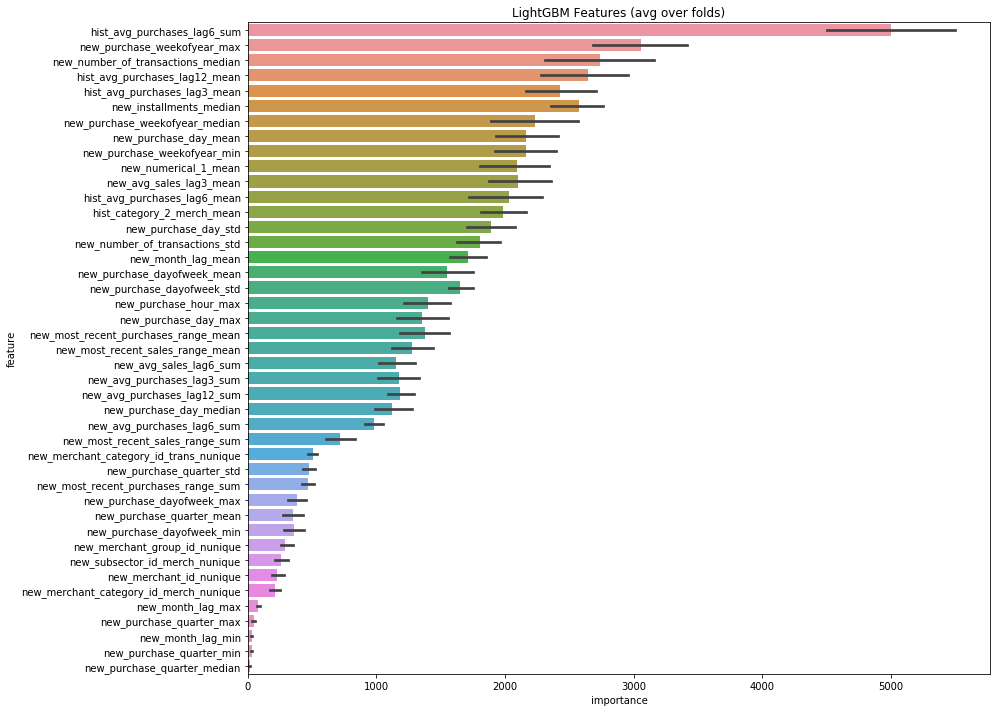

In [37]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [38]:
clf.save_model('models/lightgbm_selected.txt')

In [ ]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)